In [1]:
# CV of SBE: similarity based emulator

import sys, os, glob, pickle, toml, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold,  KFold
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

sys.path.append('../../MOASMO_support')
from MOASMO_parameter_allbasin_emulator import *

In [2]:
# evaluation functions
# evaluate

def evaluate_cv(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros(len(cv_results))
    rmse_train = np.nan * np.zeros(len(cv_results))
    cc_test = np.nan * np.zeros(len(cv_results))
    cc_train = np.nan * np.zeros(len(cv_results))
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using 
        rmse_test[fold] = get_rmse(y_test, y_test_pred)
        rmse_train[fold] = get_rmse(y_train, y_train_pred)
        cc_test[fold] = get_cc(y_test, y_test_pred)
        cc_train[fold] = get_cc(y_train, y_train_pred)
            
    return rmse_test, rmse_train, cc_test, cc_train


def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]


In [3]:
# train the model
def rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, modelconfig={'n_estimators': 100, 'random_state': 42}):

    if True:

        rf_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            # print(f"RF Fold {fold}")
        
            train_index = indices['train_index']
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new RandomForestRegressor for each fold
            rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
            # Train the model
            rf_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = rf_model.predict(x_test)
            y_train_pred = rf_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            rf_cv_results[fold] = {
                # 'model': rf_model,
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
    return rf_cv_results



def bpnn_train_and_evaluate_fold(args):
    fold, indices, x_all, y_all, modelconfig = args
    
    train_index = indices['train_index']
    test_index = indices['test_index']
    
    x_train, x_test = x_all[train_index], x_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    # Initialize scalers
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize the input features
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    
    # Normalize the target values
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Initialize a new MLPRegressor for each fold
    bp_model = MLPRegressor(**modelconfig)
    
    # Train the model
    bp_model.fit(x_train_scaled, y_train_scaled)

    # Predict on the test set
    y_test_pred_scaled = bp_model.predict(x_test_scaled)
    y_train_pred_scaled = bp_model.predict(x_train_scaled)

    # Inverse transform the predicted outputs
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

    if y_test_pred.ndim == 1 and y_test.ndim == 2:
        y_test_pred = y_test_pred[:, np.newaxis]
        y_train_pred = y_train_pred[:, np.newaxis]
    

    # Store results
    fold_result = {
        'train_index': train_index,
        'test_index': test_index,
        'y_train': y_train,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
    }

    return fold, fold_result



def bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, modelconfig={'hidden_layer_sizes': (100,), 'max_iter': 2000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True}):

    with Pool(processes=ncpus) as pool:
        # Prepare arguments for each fold
        args = [(fold, indices, x_all, y_all, modelconfig) for fold, indices in cv_indices.items()]
            
        # Parallelize the cross-validation loop
        results = pool.map(bpnn_train_and_evaluate_fold, args)
        
        # Collect results
        ann_cv_results = {fold: result for fold, result in results}

    return ann_cv_results


# Load data

In [4]:
# load data function, taken from ~/CTSM_repos/CTSM_calibration/src/MOASMO_support/MOASMO_parameter_allbasin_emulator.py
def load_basin_data():
    infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
    infile_param_info = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/parameter/CTSM_CAMELS_calibparam_2410.csv'
    infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
    inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator"
    path_CTSM_case = f'/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_emulator'
    iterend = 1 # only read data from iter-0
    suffix = 'LSEnormKGE'
    
    outpath = f"{inpath_moasmo}/LSE_allbasin"
    os.makedirs(outpath, exist_ok=True)
    
    # Load data: same for all iterations
    df_basin_info = pd.read_csv(infile_basin_info)
    df_param_info = pd.read_csv(infile_param_info)

    all_index = np.arange(len(df_basin_info))
    
    file_defa_param = f'{outpath}/camels_627basin_ctsm_defa_param.csv'
    df_param_defa = read_allbasin_defa_params(path_CTSM_case, infile_param_info, file_defa_param, len(df_basin_info))

    file_param_lb = f'{outpath}/camels_627basin_ctsm_all_param_lb.gz'
    file_param_ub = f'{outpath}/camels_627basin_ctsm_all_param_ub.gz'
    df_param_lb, df_param_ub = load_basin_param_bounds(inpath_moasmo, df_param_defa, file_param_lb, file_param_ub, all_index, suffix)

    file_camels_attribute = f'{outpath}/camels_627basin_attribute.pkl'
    df_att = read_camels_attributes(infile_basin_info, file_camels_attribute, all_index)
    
    df_att_foruse = pd.read_csv(infile_attr_foruse)
    useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
    print("The number of attributes used:", len(useattrs))
    print(useattrs)

    # Load data: outputs from each iteration
    for iter in range(0, iterend):
        file_all_param = f'{outpath}/camels_627basin_ctsm_all_param_iter{iter}.gz'
        file_all_metric = f'{outpath}/camels_627basin_ctsm_all_metric_iter{iter}.gz'
        file_all_basinid = f'{outpath}/camels_627basin_ctsm_all_basinid_iter{iter}.gz'
        
        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, df_param_defa, df_basin_info, iter, file_all_param, file_all_metric, file_all_basinid, all_index, suffix)
        
        df_basinid_i['iter'] = iter
        
        if iter == 0:
            df_param = df_param_i
            df_metric = df_metric_i
            df_basinid = df_basinid_i
        else:
            df_param = pd.concat([df_param, df_param_i])
            df_metric = pd.concat([df_metric, df_metric_i])
            df_basinid = pd.concat([df_basinid, df_basinid_i])
    
    df_param.index = np.arange(len(df_param))
    df_metric.index = np.arange(len(df_metric))
    df_basinid.index = np.arange(len(df_basinid))

    index = np.isnan(np.sum(df_metric.values, axis=1))
    df_param = df_param[~index]
    df_metric = df_metric[~index]
    df_basinid = df_basinid[~index]
    
    df_param.index = np.arange(len(df_param))
    df_metric.index = np.arange(len(df_metric))
    df_basinid.index = np.arange(len(df_basinid))
    
    print('Number of nan samples:', np.sum(index))
    print("Number of original parameter sets:", len(index))
    print("Number of final parameter sets:", len(df_param))

    return df_basin_info, df_param_info, df_param_defa, df_param_lb, df_param_ub, df_att, df_att_foruse, df_param, df_metric, df_basinid

In [5]:
df_basin_info, df_param_info, df_param_defa, df_param_lb, df_param_ub, df_att, df_att_foruse, df_param, df_metric, df_basinid = load_basin_data()
print('Number of basins:', len(df_basin_info))
print('Number of all parameters:', len(df_param_info))
print('Number of all attributes:', len(df_att.columns))

File exists: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/LSE_allbasin/camels_627basin_attribute.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 1363
Number of original parameter sets: 125400
Number of final parameter sets: 124037
Number of basins: 627
Number of all parameters: 16
Number of all attributes: 62


In [6]:
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator'
outpath_all = f'{inpath_moasmo}/LargeSampleEmulator_exps_out'
os.makedirs(outpath_all, exist_ok=True)
numbasin = len(df_basin_info)

In [7]:
num_cpus = 5  # Example: Use 4 CPUs

In [216]:
usecluster = 13 # 0-14: 15 clusters

# Load cluster information and extract all data corresponding to the cluster

In [217]:
# load cluster information
infile = "../../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt"
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(
    columns={"Camels_IDs": "hru_id", "flood_cluster": "clusters"}
)
df_cluster2 = pd.DataFrame()

for id in df_basin_info["hru_id"].values:
    dfi = df_cluster.loc[df_cluster["hru_id"] == id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.sel_index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster["clusters"] = df_cluster["clusters"] - 1  # starting from 0

if np.any(df_basin_info["hru_id"].values - df_cluster['hru_id'].values != 0):
    print("Mistmatch between basins and clusters")
else:
    print("basins and clusters match")

clusters = np.nan * np.zeros(len(df_basinid))
for i in range(numbasin):
    indi = df_basinid['basin_id'].values == i
    clusters[indi] = df_cluster.iloc[i]['clusters']

basins and clusters match


## extract data for the cluster

In [218]:
ind1 = df_cluster['clusters'].values==usecluster
df_basin_info_c = df_basin_info[ind1]
df_param_defa_c = df_param_defa[ind1]
df_param_lb_c = df_param_lb[ind1]
df_param_ub_c = df_param_ub[ind1]
df_att_c = df_att[ind1]

ind2 = clusters == usecluster
df_param_c = df_param[ind2]
df_metric_c = df_metric[ind2]
df_basinid_c = df_basinid[ind2]

df_param_info_c = df_param_info
df_att_foruse_c = df_att_foruse

numbasin_c = len(df_basin_info_c)

## remove parameters that are not useful for this cluster

In [219]:
index_useparam = df_param_lb_c.values[0,:] != df_param_ub_c.values[0,:]
print('use param', list(df_param_c.columns[index_useparam]))

use param ['watsat_sf', 'fff', 'medlynslope', 'hksat_sf', 'accum_factor', 'FMAX', 'om_frac_sf', 'e_ice', 'zbedrock', 'n_melt_coef', 'd_max', 'precip_repartition_nonglc_all_rain_t', 'interception_fraction', 'n_baseflow', 'liq_canopy_storage_scalar', 'baseflow_scalar']


# create model input / output

In [220]:
# Prepare model input and output
useattrs = list(df_att_foruse_c[df_att_foruse_c['att_Xie2021'].values]['Attribute_text'].values)

df_input = df_param_c.copy()
df_input["hru_id"] = df_basinid_c["hru_id"]
df_input = df_input.merge(df_att_c[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param_c.columns[index_useparam]) + useattrs
# print("Input parameters:", list(df_param.columns))
# print("Input attribuets:",  useattrs)

# if there is string attributes in the input, convert them to one-hot encoding
for att in useattrs:
    if df_input[att].dtype == "object":
        print('convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse=False)
        enc.fit(df_input[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('new columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
        df_input = pd.concat([df_input, df_enc], axis=1)
        df_input = df_input.drop([att], axis=1)
        inputnames = [i for i in inputnames if i != att] + encnames

x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

convert dom_land_cover to one-hot encoding
new columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_land_cover_2', 'dom_land_cover_3']
Input shape: (16755, 46)


In [221]:
# use normalized kge as output

df_output = df_metric_c.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all) # normalize KGE

print("Output shape:", y_all.shape)

Output shape: (16755, 1)


# Standard / Random K-Fold cross validation
Randomly split all samples from all basins into different folds

In [222]:
def get_cv_indices(df_basinid, nfold=5, rndseed=1234567890):

    random.seed(rndseed)
    np.random.seed(rndseed)

    # Initialize KFold
    kfold = KFold(n_splits=nfold, shuffle=True, random_state=rndseed)

    # Dictionary to store train and test indices
    cv_indices = {}

    # Cross-validation process to save indices
    for fold, (train_index, test_index) in enumerate(kfold.split(df_basinid)):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin}
    
    return cv_indices

# Get the indices
nfold = 5
cv_indices = get_cv_indices(df_basinid_c, nfold)

## Random Forest

In [223]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_RF_normKGE_standardCV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_cv_results = pickle.load(file)    
else:
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, num_cpus, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(rf_cv_results, file)

In [224]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_RF_normKGE_standardCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    rf_rmse_train = dtmp['rf_rmse_train']
    rf_rmse_test = dtmp['rf_rmse_test']
    rf_cc_train = dtmp['rf_cc_train']
    rf_cc_test = dtmp['rf_cc_test']

else:
    rf_rmse_test, rf_rmse_train, rf_cc_test, rf_cc_train = evaluate_cv(rf_cv_results)
    np.savez_compressed(outfile, rf_rmse_train=rf_rmse_train, rf_rmse_test=rf_rmse_test, rf_cc_train=rf_cc_train, rf_cc_test=rf_cc_test)

print(np.mean(rf_rmse_test), np.mean(rf_rmse_train), np.mean(rf_cc_test), np.mean(rf_cc_train))

0.12694430138990315 0.047724107498419724 0.9161725329285252 0.9899995294974138


## MLP

In [225]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_MLP_normKGE_standardCV_estimates.pkl'

if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        mlp_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    mlp_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(mlp_cv_results, file)


In [226]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_MLP_normKGE_standardCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    mlp_rmse_train = dtmp['mlp_rmse_train']
    mlp_rmse_test = dtmp['mlp_rmse_test']
    mlp_cc_train = dtmp['mlp_cc_train']
    mlp_cc_test = dtmp['mlp_cc_test']

else:
    mlp_rmse_test, mlp_rmse_train, mlp_cc_test, mlp_cc_train = evaluate_cv(mlp_cv_results)
    np.savez_compressed(outfile, mlp_rmse_train=mlp_rmse_train, mlp_rmse_test=mlp_rmse_test, mlp_cc_train=mlp_cc_train, mlp_cc_test=mlp_cc_test)

print(np.mean(mlp_rmse_test), np.mean(mlp_rmse_train), np.mean(mlp_cc_test), np.mean(mlp_cc_train))


0.18269639114842173 0.14109683556096259 0.8152220544792442 0.8942125636288154


# Group K-Fold cross validation
Randomly split basins into different folds

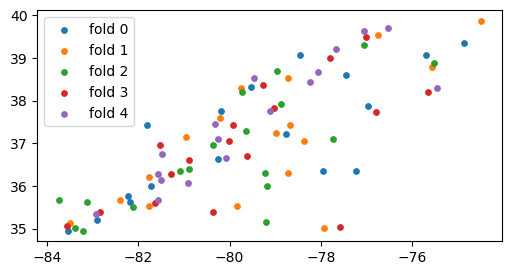

In [227]:
def get_group_cv_indices(df_basinid, nfold=5, rndseed=1234567890):

    random.seed(rndseed)
    np.random.seed(rndseed)

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    group_cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        group_cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin} 
    return group_cv_indices

# Get the indices
nfold = 5
group_cv_indices = get_group_cv_indices(df_basinid_c, nfold)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(group_cv_indices)):
    test_basin = group_cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

plt.legend()
plt.show()

## Random Forest

In [228]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_RF_normKGE_groupCV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        rf_group_cv_results = pickle.load(file)    
else:
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    rf_group_cv_results = rf_run_cross_validation_parallel(group_cv_indices, x_all, y_all, num_cpus, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(rf_group_cv_results, file)

In [229]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_RF_normKGE_groupCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    rf_group_rmse_train = dtmp['rf_group_rmse_train']
    rf_group_rmse_test = dtmp['rf_group_rmse_test']
    rf_group_cc_train = dtmp['rf_group_cc_train']
    rf_group_cc_test = dtmp['rf_group_cc_test']

else:
    rf_group_rmse_test, rf_group_rmse_train, rf_group_cc_test, rf_group_cc_train = evaluate_cv(rf_group_cv_results)
    np.savez_compressed(outfile, rf_group_rmse_train=rf_group_rmse_train, rf_group_rmse_test=rf_group_rmse_test, rf_group_cc_train=rf_group_cc_train, rf_group_cc_test=rf_group_cc_test)

print(np.mean(rf_group_rmse_test), np.mean(rf_group_rmse_train), np.mean(rf_group_cc_test), np.mean(rf_group_cc_train))

0.17459392748351757 0.046611923888037726 0.8341505211484341 0.9904322562123383


## MLP

In [230]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_MLP_normKGE_groupCV_estimates.pkl'

if os.path.isfile(outfile):
    with open(outfile, 'rb') as file:
        mlp_group_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    mlp_group_cv_results = bpnn_run_cross_validation_parallel(group_cv_indices, x_all, y_all, 5, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(mlp_group_cv_results, file)


In [231]:
outfile = f'{outpath_all}/SBE_cluster{usecluster}_MLP_normKGE_groupCV_evaluation.npz'

if os.path.isfile(outfile):
    dtmp = np.load(outfile)
    mlp_group_rmse_train = dtmp['mlp_group_rmse_train']
    mlp_group_rmse_test = dtmp['mlp_group_rmse_test']
    mlp_group_cc_train = dtmp['mlp_group_cc_train']
    mlp_group_cc_test = dtmp['mlp_group_cc_test']

else:
    mlp_group_rmse_test, mlp_group_rmse_train, mlp_group_cc_test, mlp_group_cc_train = evaluate_cv(mlp_group_cv_results)
    np.savez_compressed(outfile, mlp_group_rmse_train=mlp_group_rmse_train, mlp_group_rmse_test=mlp_group_rmse_test, mlp_group_cc_train=mlp_group_cc_train, mlp_group_cc_test=mlp_group_cc_test)

print(np.mean(mlp_group_rmse_test), np.mean(mlp_group_rmse_train), np.mean(mlp_group_cc_test), np.mean(mlp_group_cc_train))

0.24941390682473924 0.13823129600293926 0.6679283058416063 0.8983478136837888
